# Computational Data Mining | Project 5

## Importing Required Libraries

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split

## Constants and Functions

In [2]:
RANDOM_SEED = 42
N_FEATURES = 20
np.random.seed(RANDOM_SEED)

In [3]:
def print_selecting_result(result: set, execution_time: float, method_name: str):
    print(f'{method_name} Execution Time: {execution_time} seconds')
    print()
    print(f'{method_name} Selected Features:')
    for feature in sorted(result):
        print(feature, end='\t')

## 1. Data Preparation (SECOM)

1.1. Load & Cleaning

In [4]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"
X = pd.read_csv(url, sep=' ', header=None)
labels_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"
labels = pd.read_csv(labels_url, sep=' ', header=None)
y = labels.iloc[:, 0]
y = y.replace(-1, 0)

In [5]:
# remove zero-variance sensors
X = X.loc[:, X.var() != 0]

# median imputation
imputer = SimpleImputer(strategy="median")
X_imp = imputer.fit_transform(X)


1.2. Standardization (Critical for SVD)

In [6]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X_imp)

print("Samples:", X_std.shape[0])
print("Features after cleaning:", X_std.shape[1])

Samples: 1567
Features after cleaning: 474


## 2. Classical Feature Selection Methods

### 2.1. Mutual Information (Filter Method)

In [7]:
def mutual_information_selecting_features(X, y, random_state: int, n_feuatures: int):
    mi_scores = mutual_info_classif(X, y, random_state=random_state)
    mi_selected_idx = np.argsort(mi_scores)[-n_feuatures:]
    mi_selected_features = set(mi_selected_idx)
    return mi_selected_features


start = time.time()
mi_selected_features = mutual_information_selecting_features(X_std, y, RANDOM_SEED, N_FEATURES)
mi_time = time.time() - start

print_selecting_result(mi_selected_features, mi_time, 'Mutual Information')

Mutual Information Execution Time: 5.8654022216796875 seconds

Mutual Information Selected Features:
31	38	39	60	115	120	121	232	260	328	329	333	363	387	425	454	455	457	459	461	

### 2.2. Random Forest + RFE (Wrapper Method)

In [8]:
def rfe_selecting_features(X, y, random_state: int, n_feuatures: int, max_depth: int) -> set:
    rf = RandomForestClassifier(
        max_depth=max_depth,
        random_state=random_state,
        n_jobs=-1
    )
    rfe = RFE(rf, n_features_to_select=n_feuatures)
    rfe.fit(X, y)
    rfe_selected_idx = np.where(rfe.support_)[0]
    rfe_selected_features = set(rfe_selected_idx)
    return rfe_selected_features


start = time.time()
rfe_selected_features = rfe_selecting_features(X_std, y, RANDOM_SEED, N_FEATURES, 5)
rfe_time = time.time() - start

print_selecting_result(rfe_selected_features, rfe_time, 'RFE')

RFE Execution Time: 304.6150631904602 seconds

RFE Selected Features:
19	23	36	38	54	58	59	60	95	96	125	144	286	293	346	357	361	387	423	446	

## 3. Algebraic Feature Ranking using SVD

$$Score_j = \sum_{i=1}^{k} \sigma_i^2 \cdot |V_{ij}|$$

In [9]:
def svd_selecting_features(X, n_features: int, k: int = 10) -> set:
    
    # 3.1. Singular Value Decomposition
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    
    # 3.2. Score Function
    weights = S[:k] ** 2
    scores = np.sum(weights[:, None] * np.abs(Vt[:k, :]), axis=0)

    # 3.3. Top-20 SVD Features
    svd_selected_idx = np.argsort(scores)[-n_features:]
    svd_selected_features = set(svd_selected_idx)
    
    return svd_selected_features, (U, S, Vt) 

    
start = time.time()
svd_selected_features, (U, S, Vt) = svd_selecting_features(X_std, N_FEATURES, 10)
svd_time = time.time() - start

print_selecting_result(svd_selected_features, svd_time, 'SVD')

SVD Execution Time: 0.3120310306549072 seconds

SVD Selected Features:
57	62	68	155	183	184	187	188	191	253	254	281	283	284	286	287	292	385	387	388	

## 4. Geometric Interpretation & Stability

### 4.1. Loadings Plot (PC1 vs PC2)

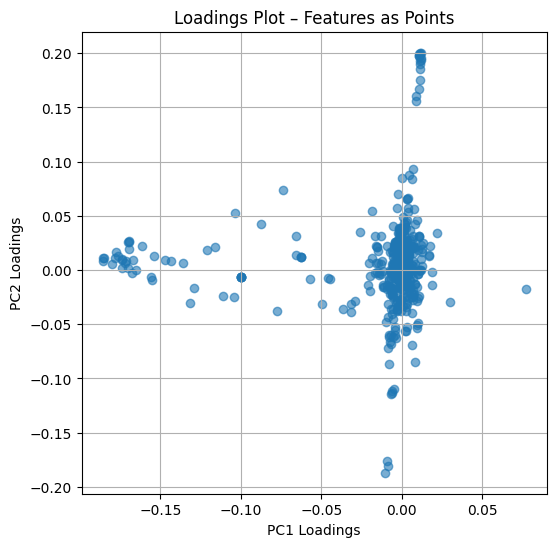

In [10]:
plt.figure(figsize=(6, 6))
plt.scatter(Vt[0], Vt[1], alpha=0.6)
plt.xlabel("PC1 Loadings")
plt.ylabel("PC2 Loadings")
plt.title("Loadings Plot – Features as Points")
plt.grid(True)
plt.show()

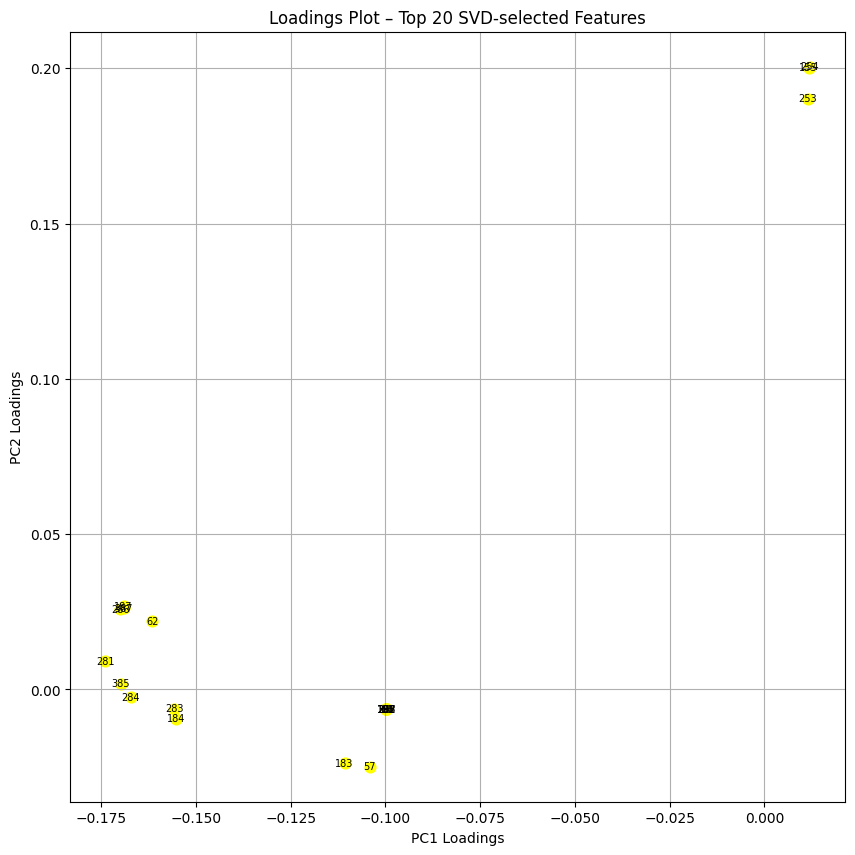

In [11]:
plt.figure(figsize=(10, 10))

plt.scatter(
    x = [Vt[0, j] for j in svd_selected_features],
    y = [Vt[1, j] for j in svd_selected_features],
    color="yellow",
    s=60
)

for j in svd_selected_features:
    plt.text(
        Vt[0, j],
        Vt[1, j],
        str(j),
        fontsize=7,
        ha="center",
        va="center"
    )

plt.xlabel("PC1 Loadings")
plt.ylabel("PC2 Loadings")
plt.title("Loadings Plot – Top 20 SVD-selected Features")
plt.grid(True)
plt.show()

### 4.2. Stability Test (5% Gaussian Noise)

In [12]:
noise = np.random.normal(0, 0.05, X_std.shape)
X_noisy = X_std + noise

In [13]:
start = time.time()
noisy_rfe_selected_features = rfe_selecting_features(X_noisy, y, RANDOM_SEED, N_FEATURES, 5)
noisy_rfe_time = time.time() - start

print_selecting_result(noisy_rfe_selected_features, noisy_rfe_time, 'Noisy RFE')

Noisy RFE Execution Time: 381.6729142665863 seconds

Noisy RFE Selected Features:
2	14	19	36	54	59	60	71	96	114	125	147	157	192	278	286	346	361	387	446	

In [14]:
start = time.time()
noisy_svd_selected_features, (U, S, Vt) = svd_selecting_features(X_noisy, N_FEATURES, 10)
noisy_svd_time = time.time() - start

print_selecting_result(noisy_svd_selected_features, noisy_svd_time, 'Noisy SVD')

Noisy SVD Execution Time: 0.2700386047363281 seconds

Noisy SVD Selected Features:
57	62	68	183	184	187	188	191	253	254	281	283	284	286	287	292	350	385	387	388	

In [15]:
rfe_stability = len(rfe_selected_features & noisy_rfe_selected_features) / N_FEATURES
svd_stability = len(svd_selected_features & noisy_svd_selected_features) / N_FEATURES

print(f"RFE stability (overlap ratio): {rfe_stability:.2f}")
print(f"SVD stability (overlap ratio): {svd_stability:.2f}")

RFE stability (overlap ratio): 0.60
SVD stability (overlap ratio): 0.95


## 5. Final Comparison using Logistic Regression

### 5.1. Evaluation & Comparison

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.3, random_state=RANDOM_SEED, stratify=y)

In [17]:
def evaluate(features, class_weight=None):
    model = LogisticRegression(max_iter=3000, class_weight=class_weight)
    X_train_sub = X_train[:, list(features)]
    X_test_sub = X_test[:, list(features)]
    model.fit(X_train_sub, y_train)
    y_pred = model.predict(X_test_sub)
    return (
        accuracy_score(y_test, y_pred),
        f1_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred)
    )

In [18]:
results = []
for selected_features in [mi_selected_features, rfe_selected_features, svd_selected_features]:
    result = list(evaluate(selected_features))
    results.append(result)

results = pd.DataFrame({
    "Method": ["Mutual Information", "RFE", "SVD"],
    "Accuracy": [x[0] for x in results],
    "F1-Score": [x[1] for x in results],
    "Precision": [x[2] for x in results],
    "Recall": [x[3] for x in results],
    "FS Time": [mi_time, rfe_time, svd_time]
})

results

,Method,Accuracy,F1-Score,Precision,Recall,FS Time
0,Mutual Information,0.929936,0.000000,0.000000,0.000000,5.865402
1,RFE,0.932059,0.058824,0.333333,0.032258,304.615063
2,SVD,0.932059,0.058824,0.333333,0.032258,0.312031


In [19]:
results_lr_balanced = []
for selected_features in [mi_selected_features, rfe_selected_features, svd_selected_features]:
    result = list(evaluate(selected_features, class_weight='balanced'))
    results_lr_balanced.append(result)

results_lr_balanced = pd.DataFrame({
    "Method": ["Mutual Information", "RFE", "SVD"],
    "Accuracy": [x[0] for x in results_lr_balanced],
    "F1-Score": [x[1] for x in results_lr_balanced],
    "Precision": [x[2] for x in results_lr_balanced],
    "Recall": [x[3] for x in results_lr_balanced],
    "FS Time": [mi_time, rfe_time, svd_time]
})

results_lr_balanced

,Method,Accuracy,F1-Score,Precision,Recall,FS Time
0,Mutual Information,0.651805,0.171717,0.101796,0.548387,5.865402
1,RFE,0.768577,0.278146,0.175000,0.677419,304.615063
2,SVD,0.690021,0.151163,0.092199,0.419355,0.312031


### 5.2. Overlap analysis

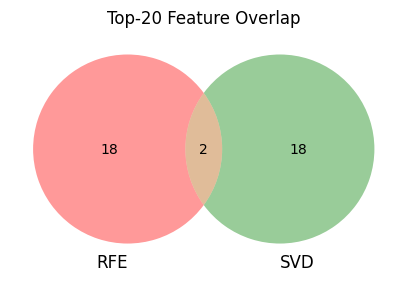

In [20]:
plt.figure(figsize=(5, 5))
venn2([rfe_selected_features, svd_selected_features], set_labels=("RFE", "SVD"))
plt.title("Top-20 Feature Overlap")
plt.show()